Exercise: Streamlining Access Permission Requests


# Imports

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, f1_score, classification_report, confusion_matrix, balanced_accuracy_score
import numpy as np
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

# Auxiliray Functions

In [48]:
def create_column_summary_table(data_frame: pd.DataFrame):
    """
    Creates a Pandas DataFrame summarizing basic EDA information for each column.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with EDA summary (% missing, % unique, n_unique, column type).
    """
    eda_list = []
    for col in data_frame   .columns:
        missing_percent = (data_frame[col].isnull().sum() / len(data_frame)) * 100
        unique_percent = (data_frame[col].nunique() / len(data_frame)) * 100
        n_unique = data_frame[col].nunique()
        dtype = data_frame[col].dtype
        eda_list.append([missing_percent, unique_percent, n_unique, dtype])

    eda_table = pd.DataFrame(
        eda_list, 
        columns=['% Missing Values', '% Unique Values', 'N Unique Values', 'Column Type'], 
        index=data_frame.columns
    )
    # Round percentage columns to 2 decimals
    eda_table['% Missing Values'] = eda_table['% Missing Values'].round(2)
    eda_table['% Unique Values'] = eda_table['% Unique Values'].round(2)
    return eda_table

In [49]:
def count_duplictated_rows(data_frame: pd.DataFrame):
    total_duplicates = data_frame.duplicated().sum()
    total_duplicate_percent = (total_duplicates / len(data_frame)) * 100
    print(f"\nTotal duplicate rows: {total_duplicates} ({total_duplicate_percent:.2f}% of dataset)")

    # Display duplicate combinations of userId and appId
    user_app_duplicates = data_frame.duplicated(subset=['userId', 'appId']).sum()
    user_app_duplicate_percent = (user_app_duplicates / len(data_frame)) * 100
    print(f"Duplicate user-app combinations: {user_app_duplicates} ({user_app_duplicate_percent:.2f}% of dataset)")

In [50]:
def show_df(data_frame: pd.DataFrame):
    print(f'Number of rows: {data_frame.shape[0]}, Number of columns: {data_frame.shape[1]}')
    print(f'Number of duplicated rows: data_frame.duplicated().sum()')
    print("First 2 rows:")
    display(data_frame.head(2))

In [51]:
def find_non_numeric_values(series):
    non_numeric = series[pd.to_numeric(series, errors='coerce').isna() & series.notna()]
    return non_numeric.unique()

In [52]:
def plot_distribution(values: pd.Series, 
                     title: str,
                     log_scale: bool = False, 
                     figsize: tuple = (12, 8),
                     bins: int = 30) -> None:
    """
    Plot distribution and boxplot for a given series of values.
    
    Parameters:
    -----------
    values : pd.Series
        Values to plot
    title : str
        Title for the plot
    log_scale : bool, default=False
        Whether to use log scale for the plots
    figsize : tuple, default=(12, 8)
        Figure size in inches (width, height)
    bins : int, default=30
        Number of bins for the histogram
    """
    # Create figure with stacked subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[2, 1])
    
    # Plot histogram
    sns.histplot(values, bins=bins, ax=ax1)
    ax1.set_title(f'Distribution of {title}')
    ax1.set_xlabel('')
    ax1.set_ylabel('Count')
    
    if log_scale:
        ax1.set_yscale('log')
    
    # Plot boxplot
    sns.boxplot(x=values, ax=ax2)
    ax2.set_xlabel(title)
    
    if log_scale:
        ax2.set_xscale('log')
    
    plt.tight_layout()
    plt.show()

In [53]:
def plot_permission_distribution(data_frame: pd.DataFrame):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # First subplot - Permissions by Seniority
    perm_by_seniority = data_frame.groupby('seniority_inverted', observed=True)['permission'].value_counts(normalize=True).unstack() * 100
    perm_by_seniority.plot(kind='bar', width=0.8, ax=ax1)

    ax1.set_title('Permission Distribution by Seniority Level')
    ax1.set_xlabel('Seniority Level')
    ax1.set_ylabel('Percentage')
    ax1.legend(title='Permission', labels=['Denied (0)', 'Granted (1)'])

    # Add percentage labels on the bars for first subplot
    for container in ax1.containers:
        ax1.bar_label(container, 
                    label_type='center',
                    fmt='%.1f%%',
                    color='white',
                    fontweight='bold')

    # Second subplot - Permissions by isMachine
    perm_by_machine = data_frame.groupby('isMachine', observed=True)['permission'].value_counts(normalize=True).unstack() * 100
    perm_by_machine.plot(kind='bar', width=0.8, ax=ax2)

    ax2.set_title('Permission Distribution by Machine Status')
    ax2.set_xlabel('Is Machine')
    ax2.set_ylabel('Percentage')
    ax2.legend(title='Permission', labels=['Denied (0)', 'Granted (1)'])

    # Add percentage labels on the bars for second subplot
    for container in ax2.containers:
        ax2.bar_label(container, 
                    label_type='center',
                    fmt='%.1f%%',
                    color='white',
                    fontweight='bold')

    # Adjust x-axis labels for isMachine
    ax2.set_xticklabels(['Human (0)', 'Machine (1)'])

    plt.tight_layout()
    plt.show()


In [54]:
def plot_is_machine_seniority_distribution(data_frame: pd.DataFrame):
    machine_by_seniority = data_frame.groupby('seniority_inverted', observed=True)['isMachine'].value_counts(normalize=True).unstack() * 100

    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = machine_by_seniority.plot(kind='bar', width=0.8)

    plt.title('Distribution of Machine vs. Human Users by Seniority Level')
    plt.xlabel('Seniority Level')
    plt.ylabel('Percentage')
    plt.legend(title='Is Machine', labels=['Human (0)', 'Machine (1)'])

    # Add percentage labels on the bars
    for container in ax.containers:
        ax.bar_label(container, 
                    label_type='center',
                    fmt='%.1f%%',
                    color='white',
                    fontweight='bold')

    plt.tight_layout()
    plt.show()

In [55]:
def plot_permission_by_dep_cat_distributions(data_frame: pd.DataFrame):
    # Create figure with a 2x2 grid
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(2, 2)
    
    # Create four axes
    ax1 = fig.add_subplot(gs[0, 0])  # top left
    ax2 = fig.add_subplot(gs[0, 1])  # top right
    ax3 = fig.add_subplot(gs[1, 0])  # bottom left
    ax4 = fig.add_subplot(gs[1, 1])  # bottom right
    
    # Plot 1: Categories (top left)
    perm_by_category = data_frame.groupby('category', observed=False)['permission'].value_counts(normalize=True).unstack() * 100
    perm_by_category = perm_by_category.sort_values(by=1, ascending=True)
    perm_by_category.plot(kind='barh', width=0.8, ax=ax1)
    ax1.set_title('Permission Distribution by Category')
    ax1.set_xlabel('Percentage')
    ax1.set_ylabel('Category')
    ax1.legend(title='Permission', labels=['Denied (0)', 'Granted (1)'])
    
    # Plot 2: Departments (top right)
    perm_by_dept = data_frame.groupby('department', observed=False)['permission'].value_counts(normalize=True).unstack() * 100
    perm_by_dept = perm_by_dept.sort_values(by=1, ascending=True)
    perm_by_dept.plot(kind='barh', width=0.8, ax=ax2)
    ax2.set_title('Permission Distribution by Department')
    ax2.set_xlabel('Percentage')
    ax2.set_ylabel('Department')
    ax2.legend(title='Permission', labels=['Denied (0)', 'Granted (1)'])
    
    # Plot 3: Office Locations (bottom left)
    perm_by_location = data_frame.groupby('officeLocation', observed=False)['permission'].value_counts(normalize=True).unstack() * 100
    perm_by_location = perm_by_location.sort_values(by=1, ascending=True)
    perm_by_location.plot(kind='barh', width=0.8, ax=ax3)
    ax3.set_title('Permission Distribution by Office Location')
    ax3.set_xlabel('Percentage')
    ax3.set_ylabel('Office Location')
    ax3.legend(title='Permission', labels=['Denied (0)', 'Granted (1)'])
    
    # Plot 4: Permission Rates by App (bottom right)
    app_stats = data_frame.groupby('appId', observed=False)['permission'].agg(['mean', 'count'])
    app_stats = app_stats.sort_values('mean', ascending=True)
    
    # Plot permission rates
    app_stats['mean'].plot(kind='hist', bins=30, ax=ax4)
    ax4.set_title('Distribution of Permission Rates Across Apps')
    ax4.set_xlabel('Permission Rate')
    ax4.set_ylabel('Count of Apps')
    
    # Add mean and median lines
    mean_rate = app_stats['mean'].mean()
    median_rate = app_stats['mean'].median()
    
    # Add mean line (red)
    ax4.axvline(x=mean_rate, color='r', linestyle='--', alpha=0.7, label=f'Mean: {mean_rate:.1%}')
    
    # Add median line (blue)
    ax4.axvline(x=median_rate, color='b', linestyle='--', alpha=0.7, label=f'Median: {median_rate:.1%}')
    
    # Add legend for mean and median lines
    ax4.legend()
    
    # Add percentage labels on bars for first three plots
    for ax in [ax1, ax2, ax3]:
        for container in ax.containers:
            ax.bar_label(container, 
                        label_type='center',
                        fmt='%.1f%%',
                        color='white',
                        fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [56]:
def plot_permission_rate_and_isMachine_dist(data_frame: pd.DataFrame):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Overall Permission Distribution
    permission_dist = data_frame['permission'].value_counts(normalize=True) * 100
    permission_dist.plot(kind='bar', ax=ax1)
    ax1.set_title('Overall Permission Distribution')
    ax1.set_xlabel('Permission')
    ax1.set_ylabel('Percentage')
    ax1.set_xticklabels(['Denied (0)', 'Granted (1)'])

    # Add percentage labels on bars
    for i, v in enumerate(permission_dist):
        ax1.text(i, v/2, f'{v:.1f}%', ha='center', color='white', fontweight='bold')

    # Plot 2: isMachine Distribution
    machine_dist = data_frame['isMachine'].value_counts(normalize=True) * 100
    machine_dist.plot(kind='bar', ax=ax2)
    ax2.set_title('Machine vs Human Distribution')
    ax2.set_xlabel('Is Machine')
    ax2.set_ylabel('Percentage')
    ax2.set_xticklabels(['Human (0)', 'Machine (1)'])

    # Add percentage labels with adjusted position for small values
    for i, v in enumerate(machine_dist):
        if v < 10:  # For small values, place text above the bar
            ax2.text(i, v + 1, f'{v:.1f}%', ha='center', color='black', fontweight='bold')
        else:  # For larger values, place text in the middle of the bar
            ax2.text(i, v/2, f'{v:.1f}%', ha='center', color='white', fontweight='bold')

    # Adjust y-axis to make room for labels above small bars
    ax2.set_ylim(0, max(machine_dist) * 1.1)  # Add 10% padding at the top

    plt.tight_layout()
    plt.show()

In [57]:
def plot_seniority_distribution(data_frame: pd.DataFrame):
    # Create figure
    plt.figure(figsize=(10, 6))

    # Calculate and sort seniority distribution
    seniority_dist = data_frame['seniority_inverted'].value_counts(normalize=True) * 100
    seniority_dist = seniority_dist.sort_index()  # Sort by seniority level

    # Create bar plot
    ax = seniority_dist.plot(kind='bar')
    plt.title('Seniority Level Distribution')
    plt.xlabel('Seniority Level')
    plt.ylabel('Percentage')

    # Add percentage labels with adjusted position for small values
    for i, v in enumerate(seniority_dist):
        if v < 10:  # For small values, place text above the bar
            plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', color='black', fontweight='bold')
        else:  # For larger values, place text in the middle of the bar
            plt.text(i, v/2, f'{v:.1f}%', ha='center', color='white', fontweight='bold')

    # Adjust y-axis to make room for labels above small bars
    plt.ylim(0, max(seniority_dist) * 1.1)  # Add 10% padding at the top

    plt.tight_layout()
    plt.show()

In [58]:
def bin_department(data_frame: pd.DataFrame):
    dept_permission_rates = data_frame.groupby('department', observed=True)['permission'].mean().reset_index()
    dept_permission_rates.columns = ['department', 'grant_rate']

    n_dept_bins = 5
    dept_permission_rates['dept_bin'] = pd.qcut(
        dept_permission_rates['grant_rate'], 
        n_dept_bins, 
        labels=[f'dept_bin_{i+1}' for i in range(n_dept_bins)]
    )

    dept_to_bin = dict(zip(dept_permission_rates['department'], dept_permission_rates['dept_bin']))

    data_frame['department_binned'] = data_frame['department'].map(dept_to_bin)

    return data_frame

In [59]:
def bin_office_location(data_frame: pd.DataFrame):
    loc_permission_rates = data_frame.groupby('officeLocation', observed=True)['permission'].mean().reset_index()
    loc_permission_rates.columns = ['officeLocation', 'grant_rate']

    n_loc_bins = 5
    loc_permission_rates['loc_bin'] = pd.qcut(
        loc_permission_rates['grant_rate'], 
        n_loc_bins, 
        labels=[f'loc_bin_{i+1}' for i in range(n_loc_bins)]
    )

    loc_to_bin = dict(zip(loc_permission_rates['officeLocation'], loc_permission_rates['loc_bin']))

    # Step 8: Apply location binning to original dataframe
    data_frame['officeLocation_binned'] = data_frame['officeLocation'].map(loc_to_bin)

    return data_frame

In [99]:
def train_and_evaluate(df_train, df_test, categorical_features, numeric_features, model_path=None):
    """Train CatBoost model with CV and evaluate on test set."""
    print("Feature Information:")
    print(f"Categorical features: {categorical_features}")
    print(f"Numeric features: {numeric_features}")
    
    # Calculate class weights
    class_counts = df_train['permission'].value_counts()
    n_samples = len(df_train)
    n_classes = len(class_counts)
    class_weights = {i: n_samples / (n_classes * count) for i, count in class_counts.items()}
    
    # Good default parameters for CatBoost
    params = {
        'iterations': 500,
        'depth': 6,
        'learning_rate': 0.1,
        'l2_leaf_reg': 3,
        'min_data_in_leaf': 20,
        'max_bin': 200,
        'random_strength': 1,
        'bagging_temperature': 1,
        'class_weights': class_weights,
        'thread_count': -1,  # Use all CPU cores
        'task_type': 'GPU',  # Enable GPU training
        'devices': '0',      # Use first GPU device
        'verbose': False,
        'gpu_ram_part': 0.95,     # Use 95% of GPU memory
        'pinned_memory_size': '1gb',
        'class_names': [0, 1],
    }
    
    # Prepare features
    X = df_train[categorical_features + numeric_features]
    y = df_train['permission']
    
    # Create stratification column
    df_train['strat'] = df_train['permission'].astype(str) + '_' + df_train['isMachine'].astype(str)
    
    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    print("\nPerforming 5-fold CV...")
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, df_train['strat']), 1):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Create pools
        train_pool = Pool(
            X_fold_train,
            y_fold_train,
            cat_features=categorical_features
        )
        val_pool = Pool(
            X_fold_val,
            y_fold_val,
            cat_features=categorical_features
        )
        
        # Train model
        model = CatBoostClassifier(**params, random_seed=42)
        model.fit(train_pool, use_best_model=True)
        
        # Evaluate
        y_pred = model.predict(val_pool)
        fold_score = f1_score(y_fold_val, y_pred)
        cv_scores.append(fold_score)
        print(f"Fold {fold} F1 Score: {fold_score:.4f}")
    
    print(f"\nMean CV F1 Score: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
    
    # Train final model on full training data
    print("\nTraining final model on full training data...")
    final_model = CatBoostClassifier(**params, random_seed=42)
    
    train_pool = Pool(
        X,
        y,
        cat_features=categorical_features
    )
    
    final_model.fit(train_pool)
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': final_model.feature_names_,
        'Importance': final_model.get_feature_importance()
    }).sort_values('Importance', ascending=False)
    print("\nTop 10 Feature Importance:")
    print(feature_importance.head(10))
    
    # Evaluate on test set
    print("\nTest Set Performance:")
    X_test = df_test[categorical_features + numeric_features]
    y_test = df_test['permission']
    
    test_pool = Pool(
        X_test,
        y_test,
        cat_features=categorical_features
    )
    
    y_pred = final_model.predict(test_pool)
    y_pred_proba = final_model.predict_proba(test_pool)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # if roc_auc < 0.5:
    #     y_pred_proba = 1 - y_pred_proba
    #     fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    #     roc_auc = auc(fpr, tpr)
    
    # Store all results
    test_results = {
        'f1_score': f1_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_curve': {
            'fpr': fpr,
            'tpr': tpr
        },
        'auc_score': roc_auc,
        'y_pred_proba': y_pred_proba,
        'accuracy': balanced_accuracy_score(y_test, y_pred)
    }
    
    # Print results nicely
    print_results(test_results)
    
    # Save model if path is provided
    if model_path:
        final_model.save_model(model_path)
        print(f"\nModel saved to: {model_path}")
    
    return final_model, test_results

def print_results(results):
    """Print classification results in a formatted way."""
    print("\n" + "="*50)
    print("MODEL PERFORMANCE METRICS")
    print("="*50)
    
    # F1 Score and AUC Score
    print(f"\nF1 Score: {results['f1_score']:.4f}")
    print(f"AUC Score: {results['auc_score']:.4f}")
    
    # Classification Report
    print("\nDetailed Performance Metrics:")
    print("-"*50)
    print(results['classification_report'])
    
    # Confusion Matrix
    cm = results['confusion_matrix']
    print("Confusion Matrix:")
    print("-"*50)
    print(f"                Predicted NO  Predicted YES")
    print(f"Actual NO     {cm[0,0]:>11,d} {cm[0,1]:>13,d}")
    print(f"Actual YES    {cm[1,0]:>11,d} {cm[1,1]:>13,d}")
    
    # Additional metrics
    total = cm.sum()
    tn, fp, fn, tp = cm.ravel()
    
    print("\nAdditional Metrics:")
    print("-"*50)
    print(f"Total Samples:    {total:,d}")
    print(f"Correct:          {(tn + tp):,d}")
    print(f"Incorrect:        {(fp + fn):,d}")
    print(f"Accuracy:         {(tn + tp) / total:.4f}")
    print(f"Misclass. Rate:   {(fp + fn) / total:.4f}")
    print(f"Precision:        {tp / (tp + fp):.4f}")
    print(f"Recall:          {tp / (tp + fn):.4f}")
    print("="*50)
    
    # Plot ROC curve

    plt.figure(figsize=(8, 6))
    plt.plot(results['roc_curve']['fpr'], results['roc_curve']['tpr'], 
             color='darkorange', lw=2,
             label=f'ROC curve (AUC = {results["auc_score"]:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Section 1 - Data Inspection

### Loading data

In [61]:
users_metadata = pd.read_csv('data/users_metadata.csv')
apps_metadata = pd.read_csv('data/apps_metadata.csv')
interactions = pd.read_csv('data/interactions.csv')

### users_metadata inspection

In [62]:
show_df(users_metadata)

Number of rows: 3724, Number of columns: 6
Number of duplicated rows: data_frame.duplicated().sum()
First 2 rows:


,userId,department,officeLocation,managerId,isMachine,seniority
0,0,0.0,0,3582.0,0,5
1,1,1.0,0,1609.0,0,5


### apps_metadata inspection

In [63]:
show_df(apps_metadata)

Number of rows: 524, Number of columns: 2
Number of duplicated rows: data_frame.duplicated().sum()
First 2 rows:


,appId,category
0,0,other
1,1,Other


### interactions inspection

In [64]:
show_df(interactions)

Number of rows: 166070, Number of columns: 3
Number of duplicated rows: data_frame.duplicated().sum()
First 2 rows:


,userId,appId,permission
0,1,0,1
1,5,0,1


### Merging to one data frame

In [65]:
merged_tmp = pd.merge(interactions, users_metadata, on='userId', how='left')
merged = pd.merge(merged_tmp, apps_metadata, on='appId', how='left')

## Merged data frame inspection

In [66]:
print(create_column_summary_table(merged))
print(count_duplictated_rows(merged))

                % Missing Values  % Unique Values  N Unique Values Column Type
userId                      0.00             2.24             3724       int64
appId                       0.00             0.20              332       int64
permission                  0.00             0.00                2       int64
department                  3.31             0.02               30     float64
officeLocation              0.00             0.03               45       int64
managerId                  19.87             0.38              632      object
isMachine                   0.00             0.00                2       int64
seniority                   0.00             0.00                5       int64
category                    1.05             0.01               24      object

Total duplicate rows: 0 (0.00% of dataset)
Duplicate user-app combinations: 0 (0.00% of dataset)
None


In [67]:
merged.sample(5)

,userId,appId,permission,department,officeLocation,managerId,isMachine,seniority,category
82347,2791,31,1,1.0,3,388.0,0,4,other
67612,2960,22,1,3.0,6,NaN,0,5,other
72360,3620,25,1,14.0,3,231.0,0,4,Other
134383,3569,85,0,1.0,0,3181.0,0,5,project management
25750,1647,8,0,NaN,6,NaN,0,5,Other


In [68]:
# Category column has some values in upper case, converting to lower case to avoid duplicate values
merged['category'] = merged['category'].str.lower()

In [69]:
# Checking why managerId is in object type
non_numeric_managers = find_non_numeric_values(merged['managerId'])
print("Non-numeric values in managerId:")
print(non_numeric_managers)

Non-numeric values in managerId:
['!!%' '&>=' '&$=' '>=$' '#=%' '&!#' '><%' '$<&' '<><' '%#$' '&>&' '#=&'
 '#%$' '&&%' '$>#' '!#=' '>#$' '==$' '!!#' '%!>' '<%&' '$%!' '$&=' '<#$'
 '>%!' '$=#' '$%#' '===' '&<$' '<&<' '=$=' '!#&' '&#=' '=&=' '<#%' '=#$'
 '#&>' '$=!' '&!<' '!=$' '>&=' '#&%' '=#%' '#&!' '<!&' '%#>' '>%&' '%$>'
 '>&&' '%==' '>&>' '!!$' '&>$' '!!!' '<%=' '<<=' '<=>' '><&' '!>$' '=$<'
 '%%&' '=>&' '&<>' '#$&' '<<<' '=!!' '<>>' '=>#' '=#=']


### Data imputation

In [70]:
merged['department'] = merged['department'].fillna('unknown')
merged['category'] = merged['category'].fillna('novalue')
merged['managerId'] = merged['managerId'].fillna('novalue')

### Summary
1. I merged the 3 data sets into one, after checking for duplicated rows.
2. The merged data set conatains the exact amount of rows as interactions set, meaning our merge was done correctly.
3. The number of unique appId's is 332 while the app_metadata contains 524 id's, meaning not all appId's are in interactions set.
4. All users from users_metadata set have at least one interaction.
5. No duplicated rows in the merged set.
6. managerId column has both numeric id's which are valid users in users_metadata and string ids. In the scope of the assignment I assume treating the column as categorical will bg enough.
7. All id's columns should be converted to 'category' type.
8. 'department' and 'officeLocation' should be converted to 'category' type.
9. 'seniority' column requires careful handling
10. Imputed missing values in 'department', 'managerId' and 'category' columns.

# Section 2 - Data Type and Encoding Preparation

### Converting to 'category' type

In [71]:
merged['userId'] = merged['userId'].astype('category')
merged['appId'] = merged['appId'].astype('category')
merged['managerId'] = merged['managerId'].astype('category')
merged['department'] = merged['department'].astype('category')
merged['officeLocation'] = merged['officeLocation'].astype('category')

### Handle seniority column

In [72]:
max_seniority = merged['seniority'].max()
merged['seniority_inverted'] = max_seniority - merged['seniority']
merged['seniority_inverted'] = pd.Categorical(merged['seniority_inverted'], ordered=True, categories=sorted(merged['seniority_inverted'].unique()))

# I could use the following piece of code:
# merged['seniority'] = pd.Categorical(merged['seniority'], ordered=True, categories=[5, 4, 3, 2, 1]))
# But for intuitive understanding, I decided to invert the scale.

# Section 3 - Exploratory Data Analysis

### Plot number of interactions per User

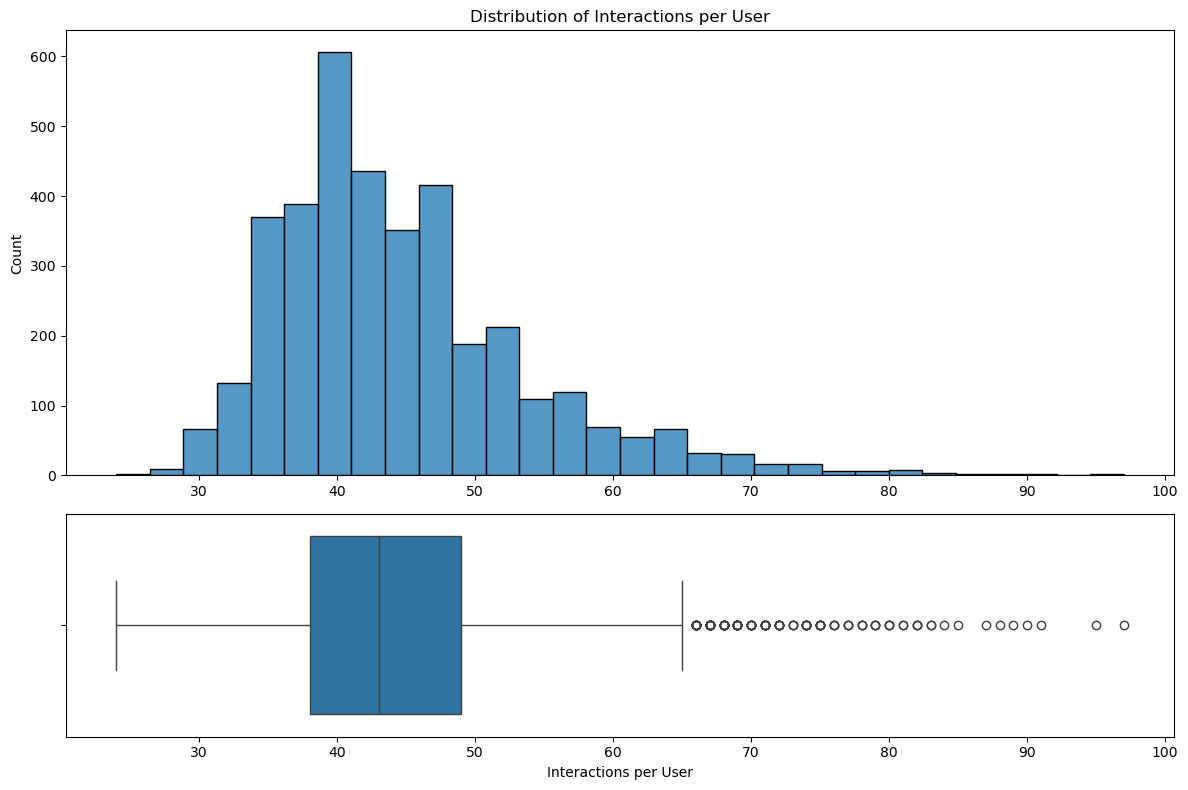

In [73]:
# The x-axis shows the number of interactions
# The y-axis shows the count of users who have that many interactions
interactions_per_user = merged.groupby('userId', observed=True).size()
plot_distribution(interactions_per_user, "Interactions per User")

### Plot number of interactions per App

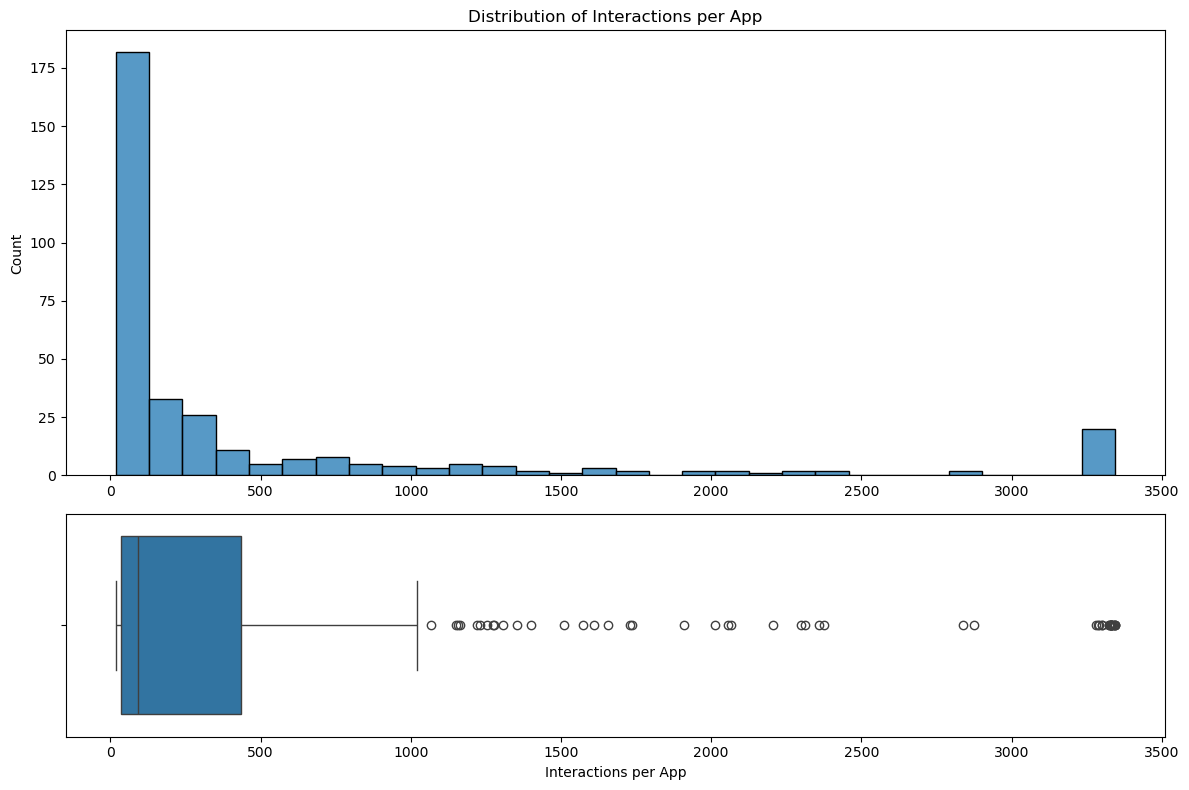

In [74]:
# The x-axis shows the number of interactions
# The y-axis shows the count of apps who have that many interactions
interactions_per_user = merged.groupby('appId', observed=True).size()
plot_distribution(interactions_per_user, "Interactions per App")

### Insights
1. Interaction per user - close to normal dist' with a slight right tail. showing there are few users with relatively high amount of interactions.
2. Interaction per app - highly right-skewed distribution, where majority of the apps have relatively few interactions and small amount of apps have significantly more interactions.
These may be useful in crafting features in order to do "Profiling" for users and apps.

### Plot permission, isMachine and seniority distribution

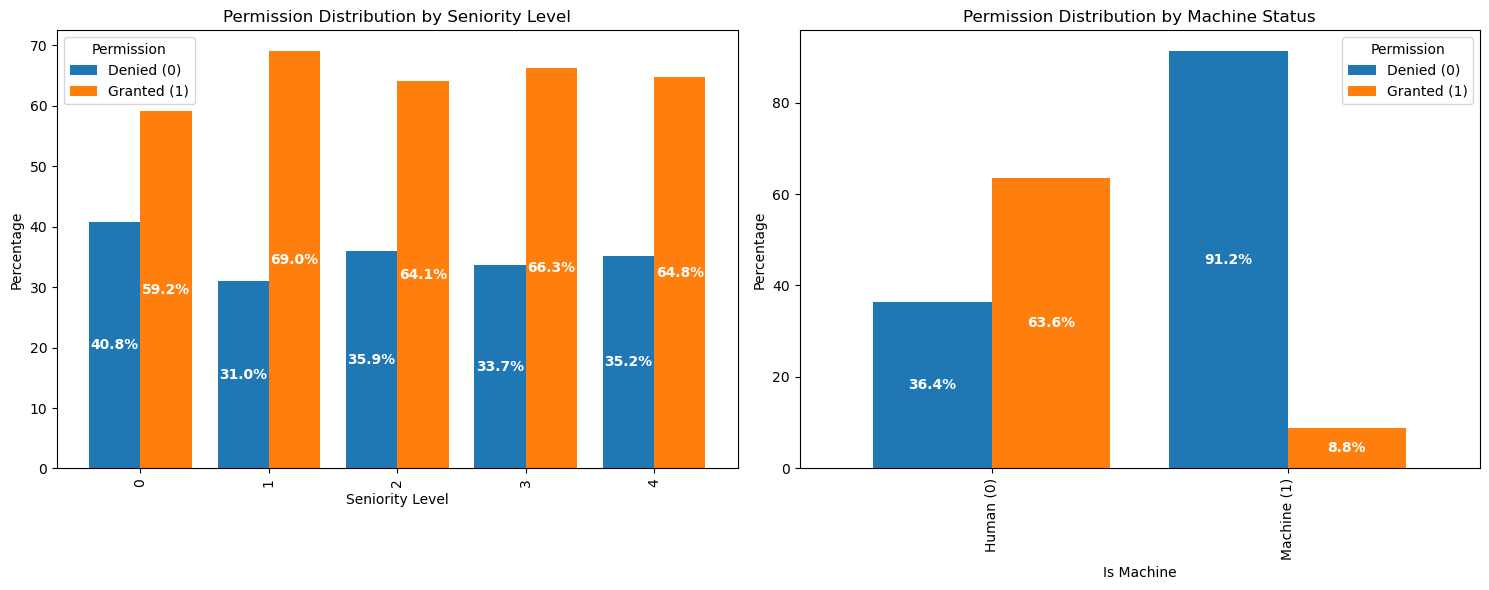

In [75]:
# Distribution of permission per seniority and isMachine
plot_permission_distribution(merged)

<Figure size 1000x600 with 0 Axes>

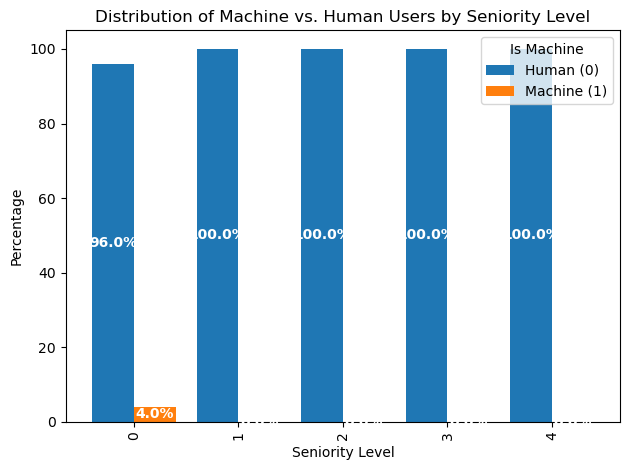

In [76]:
# Distribution of isMachine per seniority
plot_is_machine_seniority_distribution(merged)

### Insights
1. isMachine is very predictable though there are few interactions coming from machine.
2. isMachine exists only for the lowest seniority level (at least in the data).
3. crafting a feature that combine isMachine and seniority may be useful

### Plot permission by category

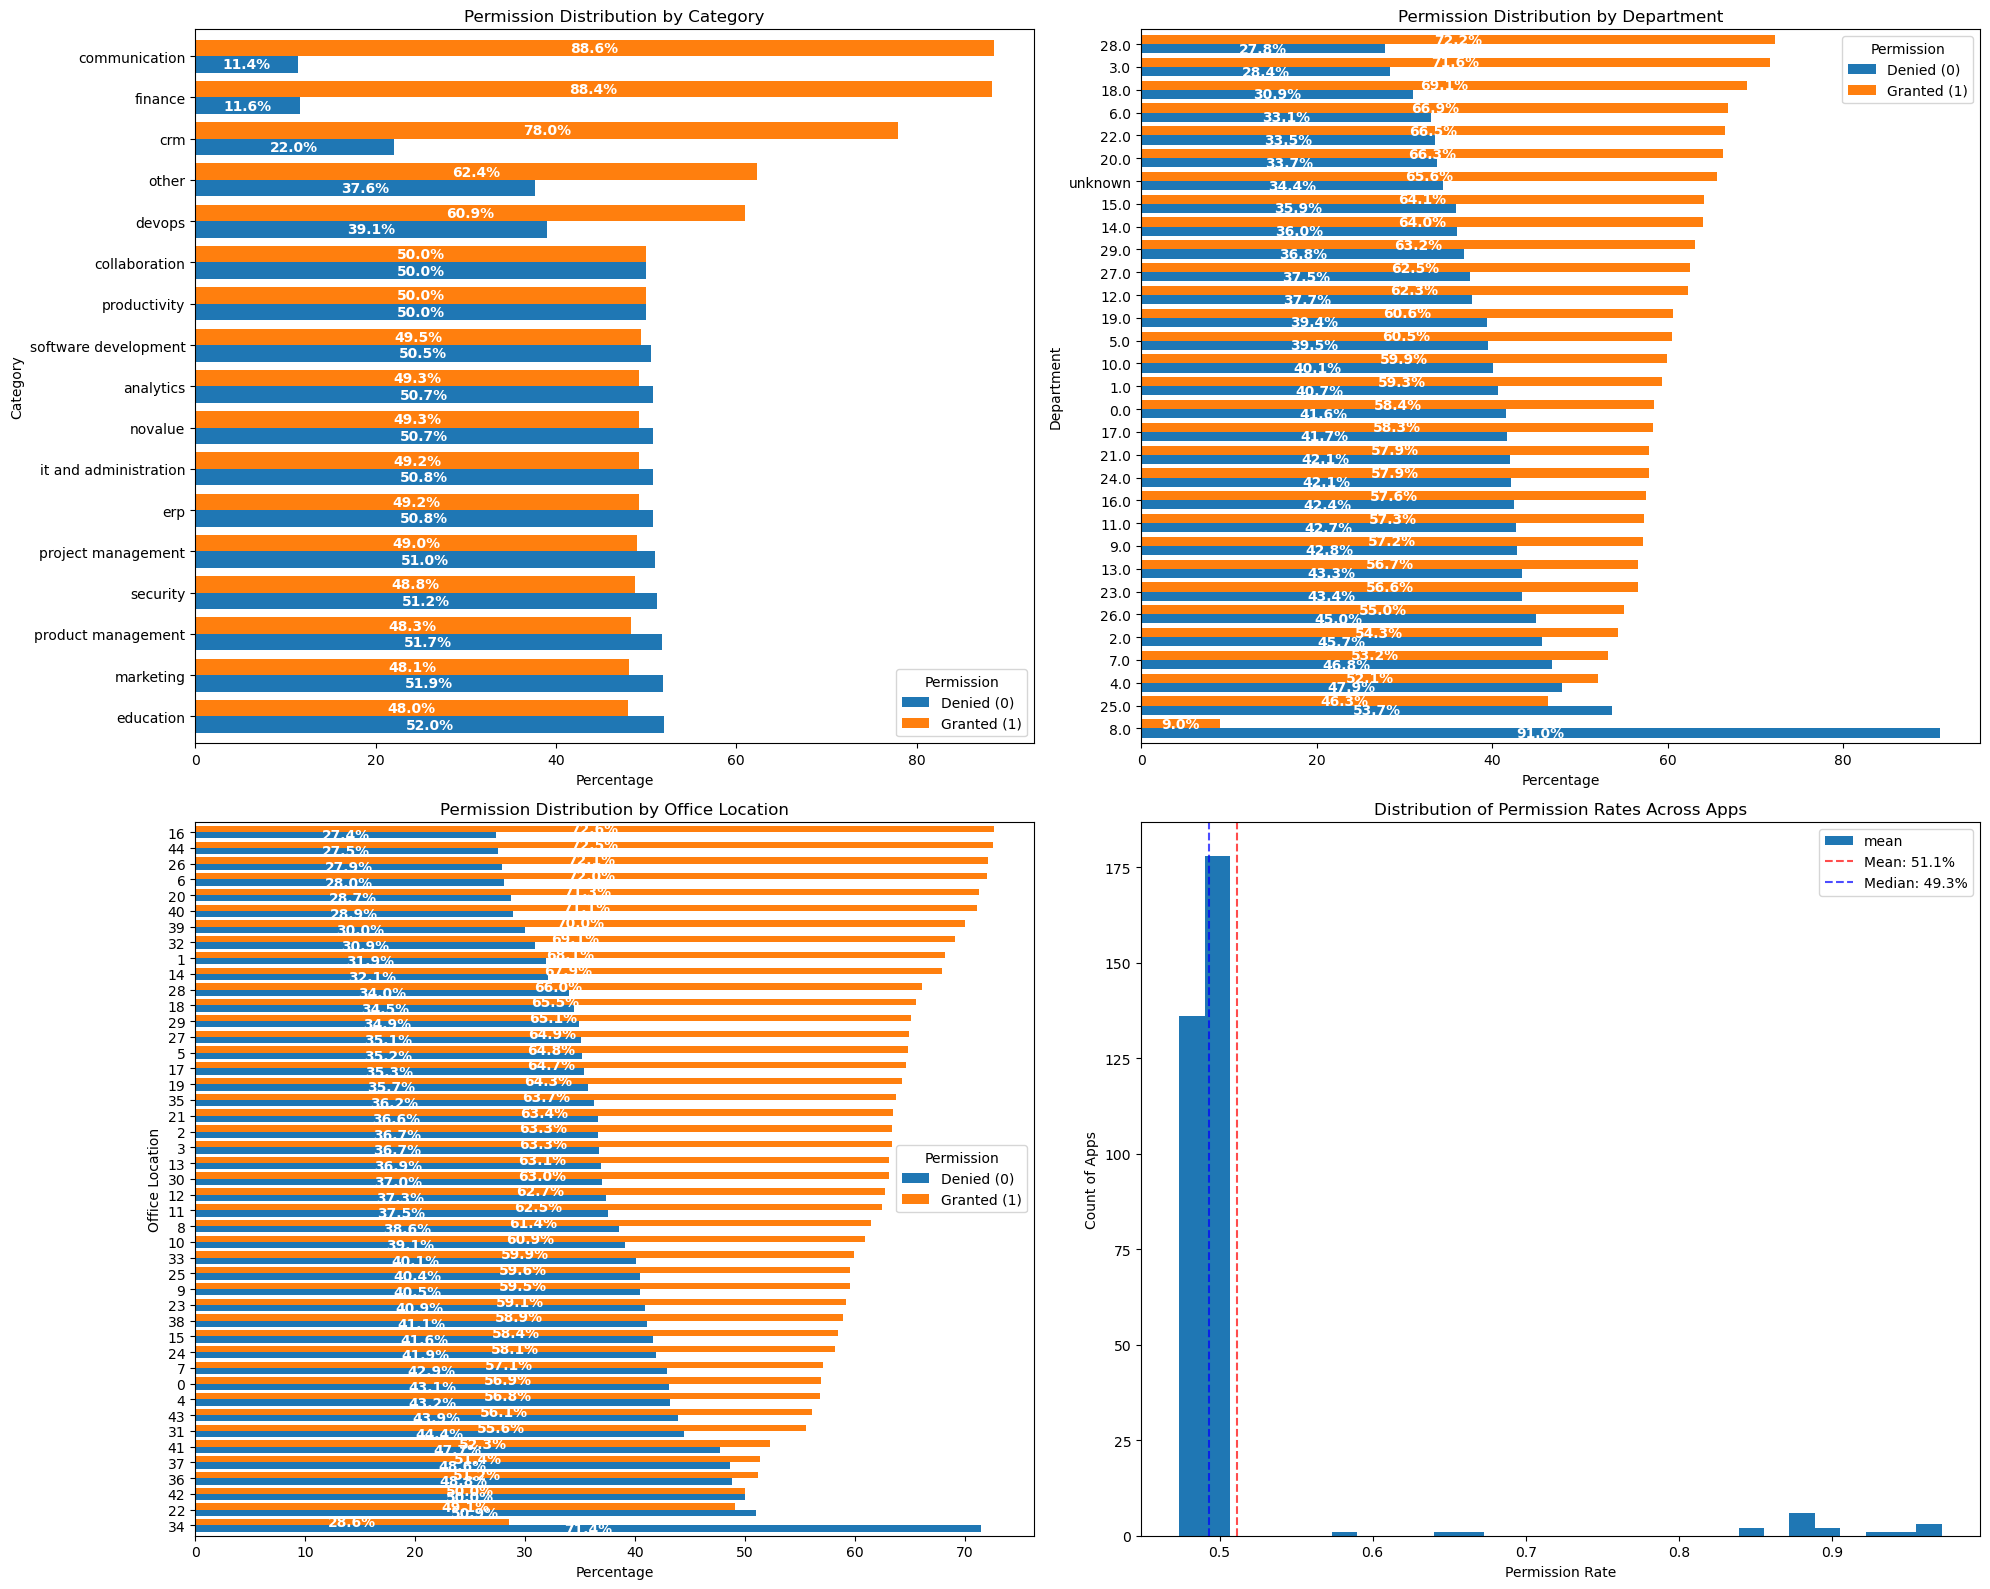

In [77]:
# Distribution of permission by department, category and officeLocation
plot_permission_by_dep_cat_distributions(merged)

### Insights
1. category is relatively a good predictive feature.
2. department shows significant variation in permission rate.
3. officeLocation shows significant variation in permission rate.
4. I'm considering combining departments by permission rate and same for officeLocation. Bining them will reduce the number of categories for the encoding.
5. After splitting to train and test sets, I should check these plots didn't change significantly.

### Plot permission rate and isMachine dist'

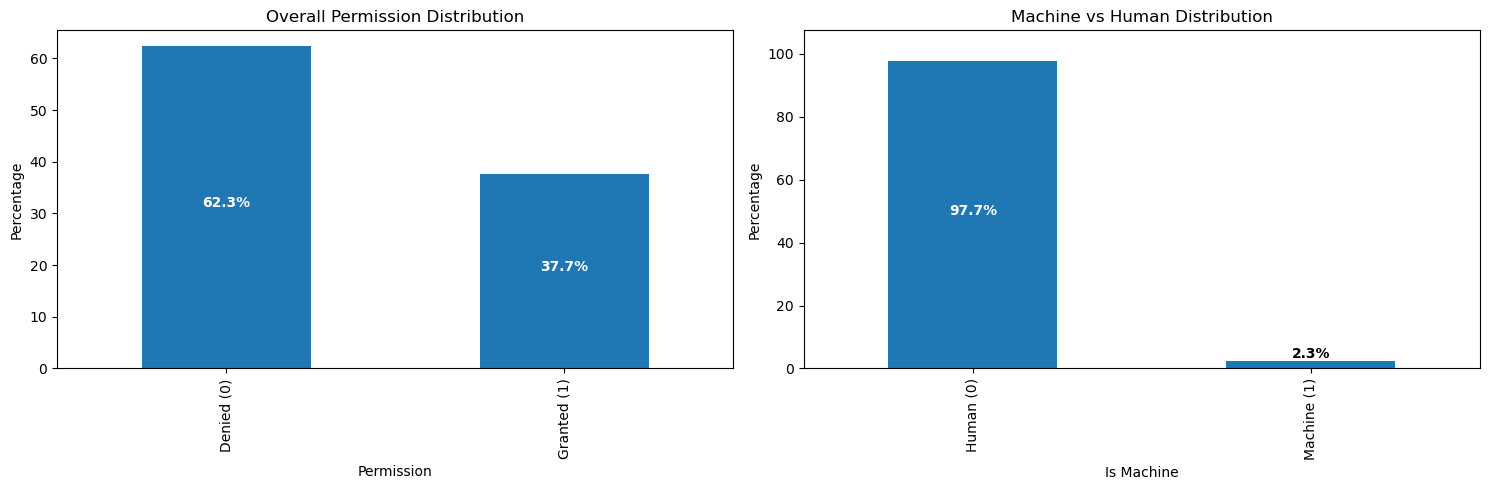

In [78]:
plot_permission_rate_and_isMachine_dist(merged)

### Plot seniority dist'

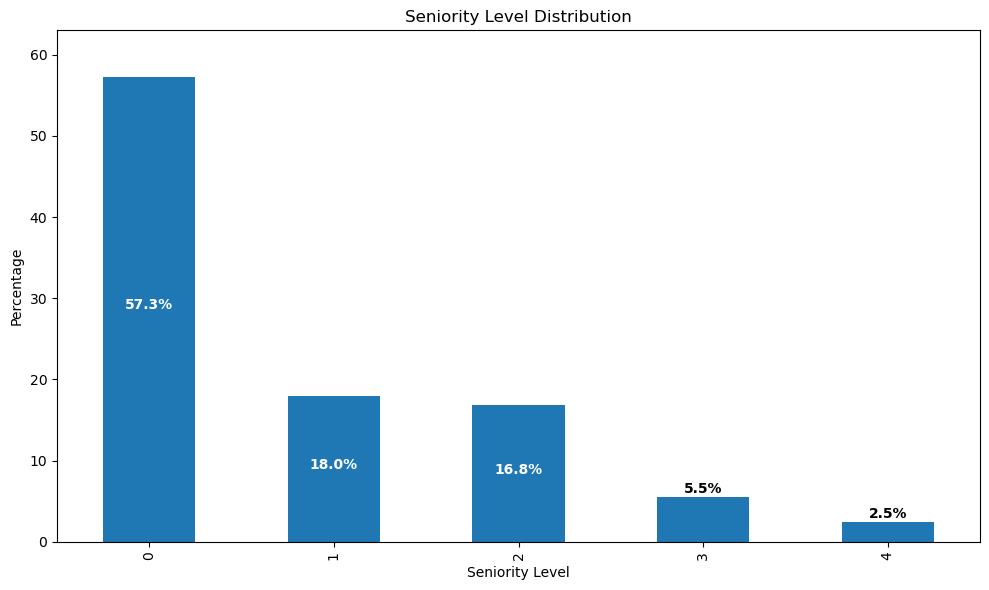

In [79]:
plot_seniority_distribution(merged)

## Summary
After performing the EDA step, I suggest taking the following actions:
1. Stratify by permission and isMachine to keep proportion of these features.
2. Verify train and test set have similar dist' of the plots I created above.
3. Bin departments and officeLocation columns by permission rate in order to reduce the number of categories.
4. Combine isMachine and seniority into one features as it has a good signal for the model.

# Section 4 - Train Test Split

In [80]:
merged['strat'] = merged['permission'].astype(str) + '_' + merged['isMachine'].astype(str)

df_train, df_test = train_test_split(
    merged, 
    test_size=0.2, 
    random_state=111,
    stratify=merged['strat']
)

# Remove the helper column
df_train = df_train.drop('strat', axis=1)
df_test = df_test.drop('strat', axis=1)

## Validate dist' didn't change significantly in test set

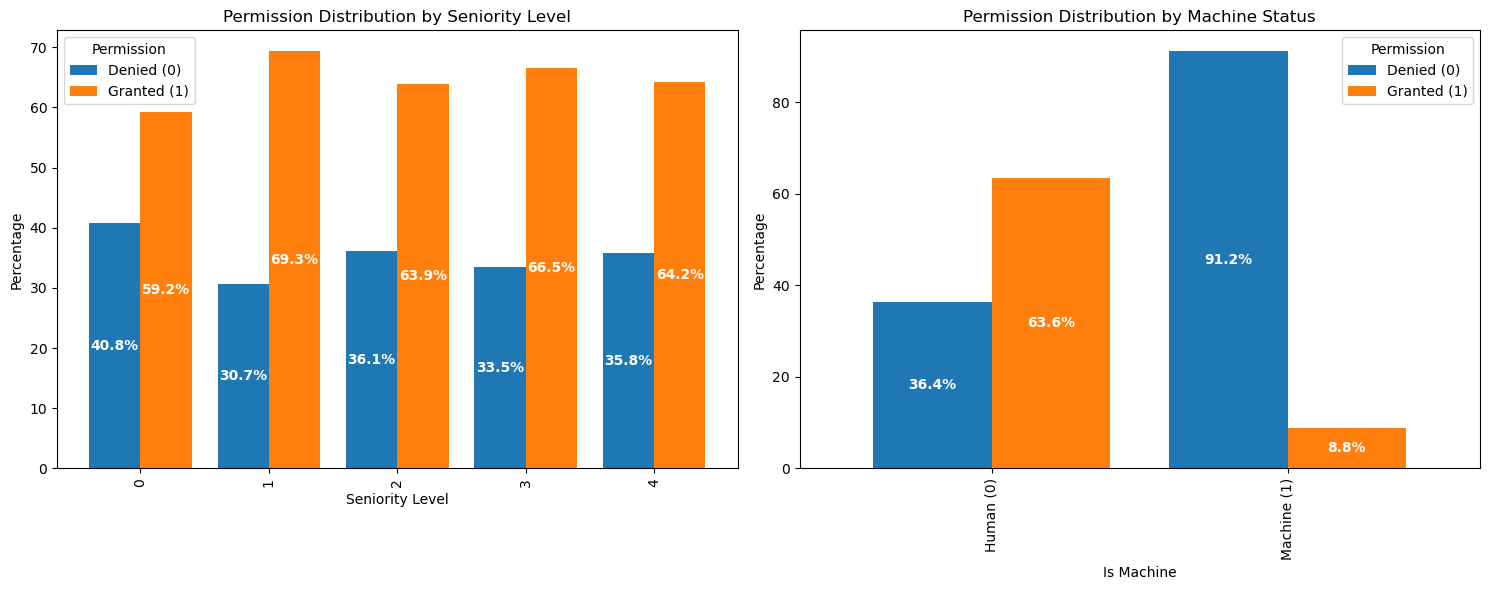

In [81]:
plot_permission_distribution(df_test)

<Figure size 1000x600 with 0 Axes>

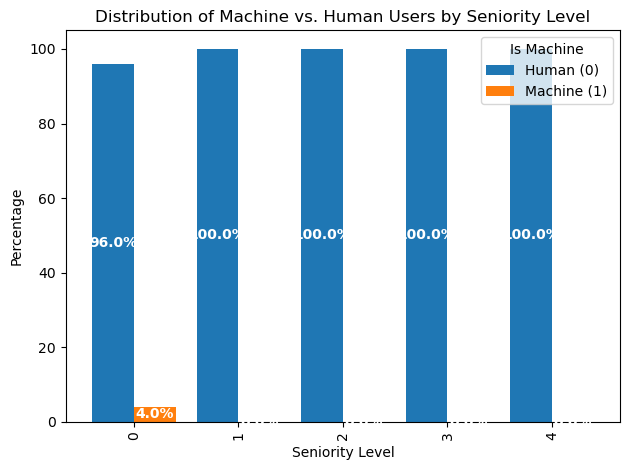

In [82]:
plot_is_machine_seniority_distribution(df_test)

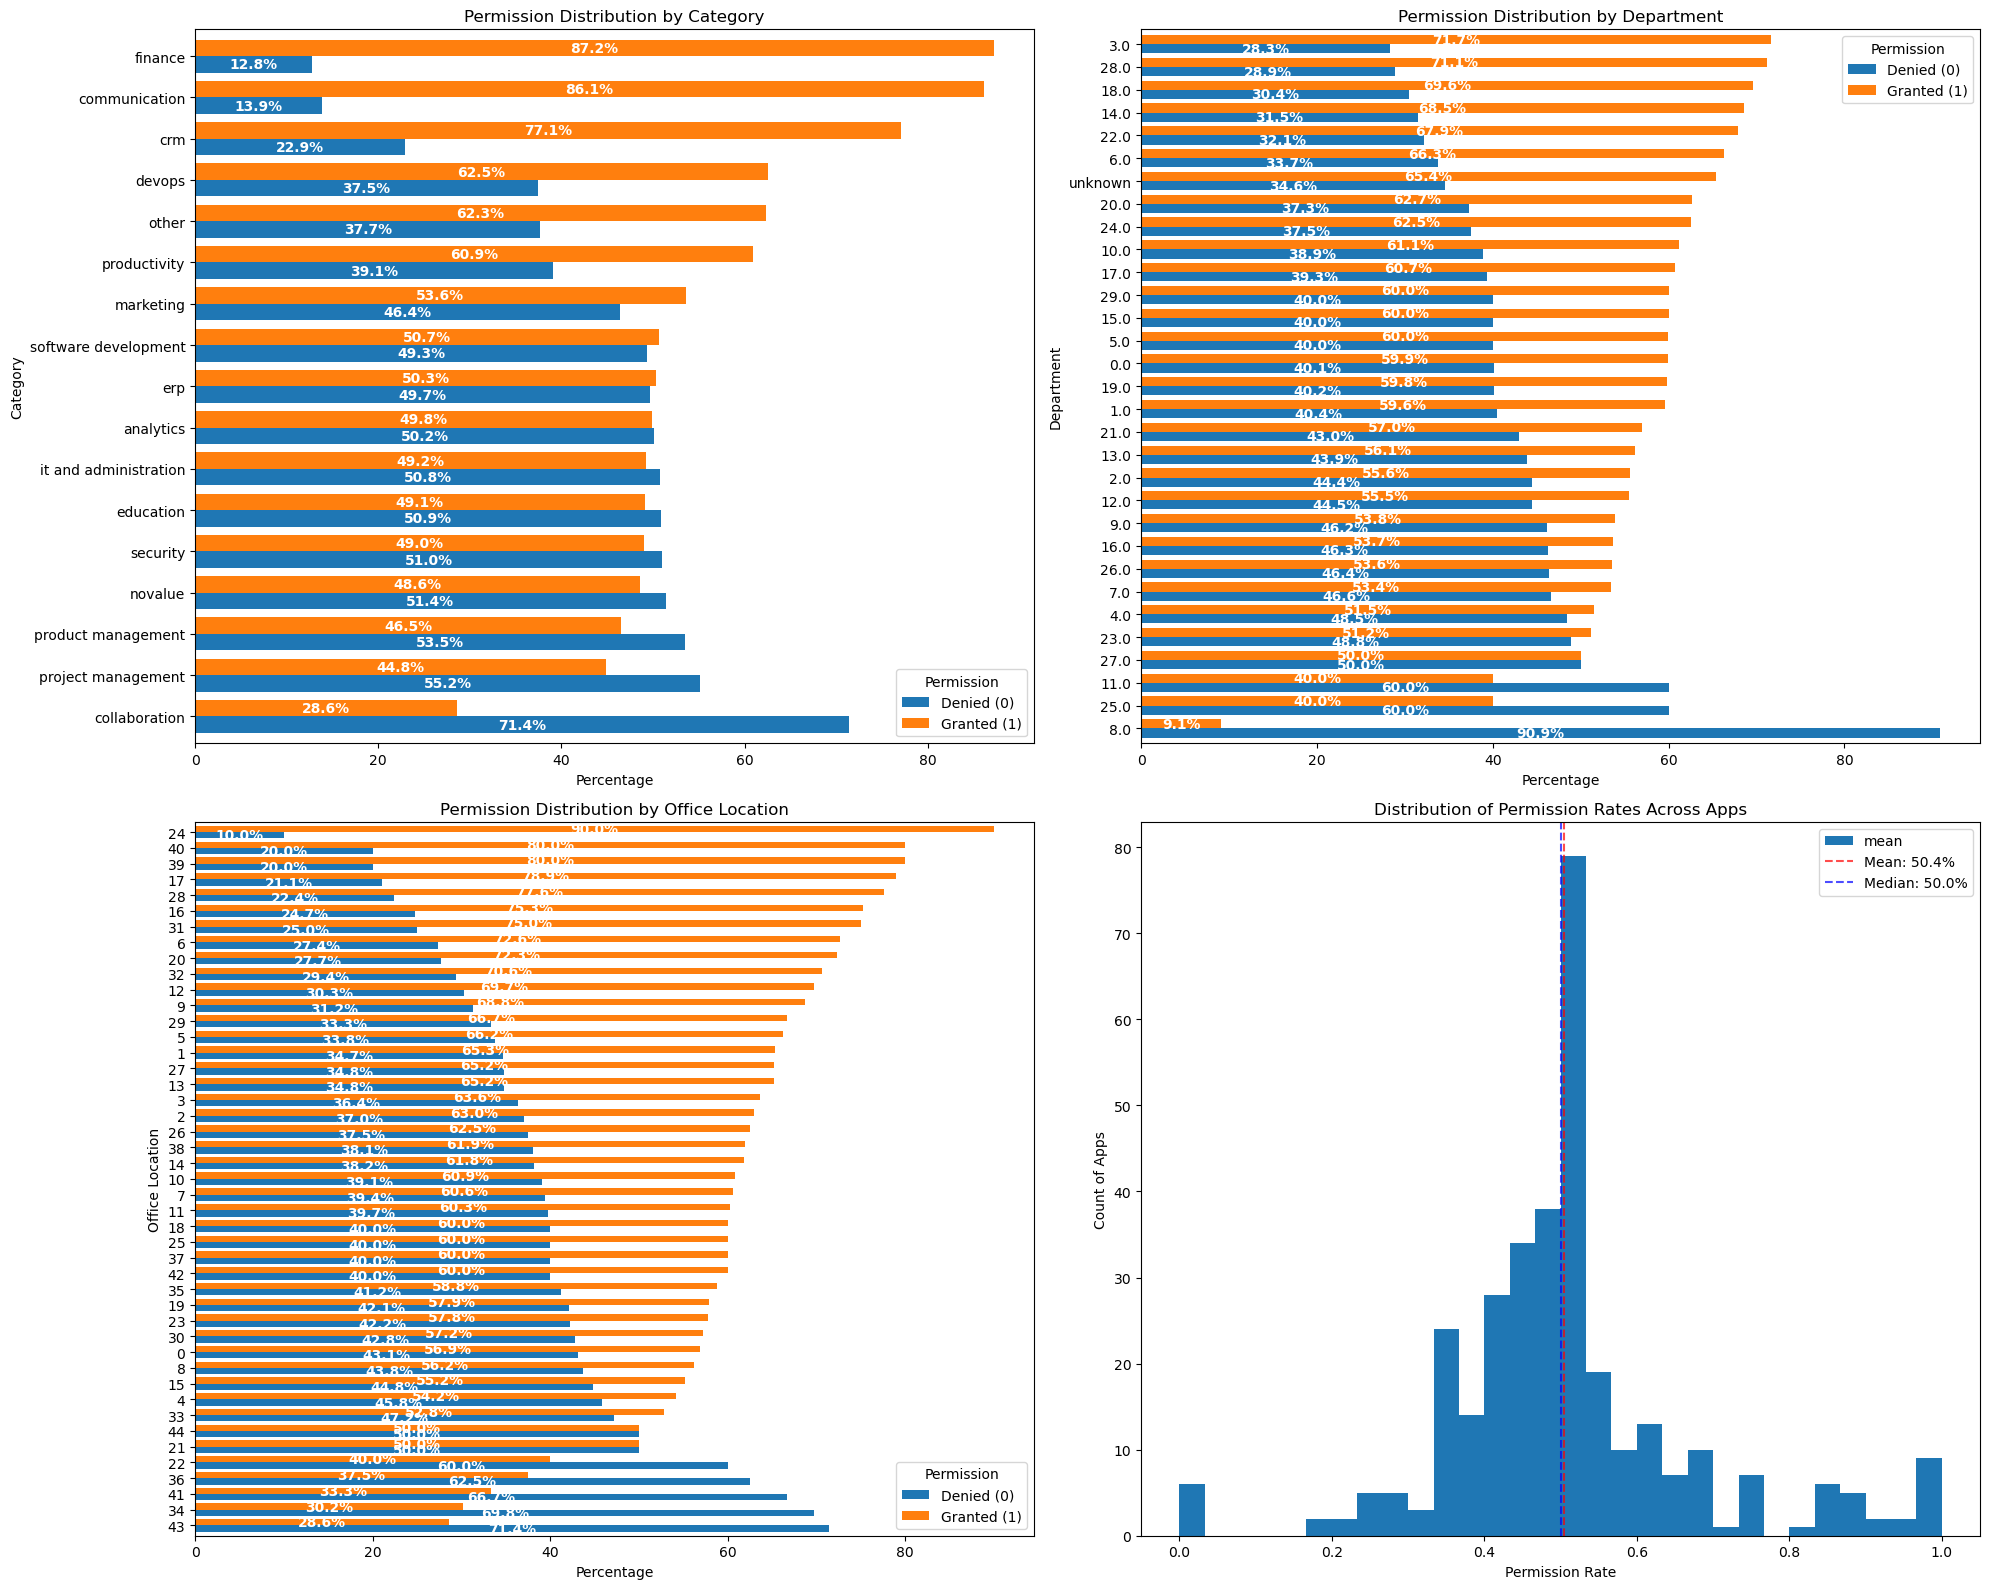

In [83]:
plot_permission_by_dep_cat_distributions(df_test)

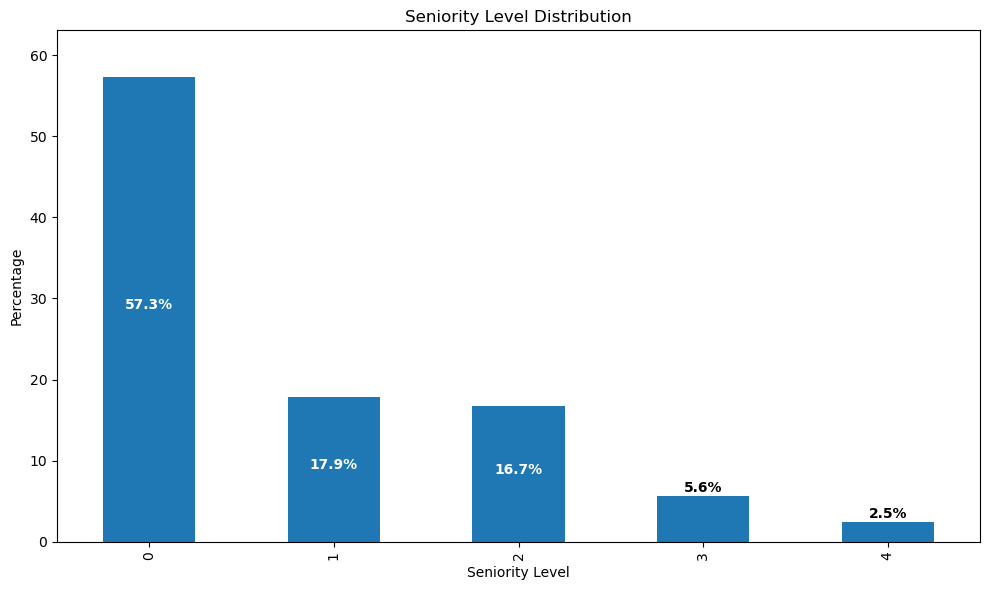

In [84]:
plot_seniority_distribution(df_test)

## Summary:
1. We will use the train df for training the model.
2. The dist' of several plots changed a bit between the complete data set and test set. For correctness, we should compare it to the dist' of the train set, I do not attach here their plots to keep the readiness simple, but we can say with good confidence the dist' show just a slight difference between train and test set.
3. during the model training, I will use CV - the data has "Sub categories"  - I refer to combinations of dep' and location, manager and user and so on. in order to be sure the model sees all the data, CV is suggested.

# Section 5 - Data Preparation

In [85]:
# Binning departments and officeLocation
df_train = bin_department(df_train)
df_train = bin_office_location(df_train)

In [86]:
# Adding department and officeLocation to test set
user_dept_loc_df = df_train.groupby('userId',  observed=True).agg({'department_binned': 'first', 'officeLocation_binned': 'first'}).reset_index()
df_test = pd.merge(df_test, user_dept_loc_df, on='userId', how='left')

In [87]:
# Creating a feature that combines isMachine and seniority
df_train['machine_seniority'] = df_train['isMachine'].astype(str) + '_' + df_train['seniority'].astype(str)
df_test['machine_seniority'] = df_test['isMachine'].astype(str) + '_' + df_test['seniority'].astype(str)

# Section 6 - Model Selection

### Discussion
The main facts which derive the motivation for the right model are:

1. Binary target.
2. Multiple categorical features + considering the fact for unknown categories in the future (robust handling of unseen values at inference time).
3. Need for model explainability in order to justify predictions.
4. The data contains complex non-linear relationships between features and permission outcomes

Given these facts, gradient boosting models are well-suited for this our task.
Theyc can handle complex categorical data without extensive preprocessing and capture the non-linear patterns we see in the plots.
Linear models would miss the nuanced patterns we see across departments and categories for example.
While neural networks could potentially capture these complexities, they require much more data to perform well, need extensive hyperparameter tuning, and offer less interpretability. 
Gradient boosting models gives us clear feature importance metrics.
Gradient boosting can also handles new, unseen categories during inference, which makes it more robust than other methods.
Gradient boosting models much more resistance to multicollinearity and do not require data scaling/normalization.
I will use CatBoost as it handles cat' data well and new unseen data (in case there is such).

# Section 7 - Model Training + Evaluating

## Using Optuna for tuning - As I struggled with my pc performance, this code ran very slow, but this is the code I would run usually. I leave the implementation here.

In [88]:
# def objective(trial, df_train, categorical_features, numeric_features):
#     """Optuna objective function for hyperparameter optimization."""
#     # Create stratification column
#     df_train['strat'] = df_train['permission'].astype(str) + '_' + df_train['isMachine'].astype(str)
    
#     # Calculate class weights
#     class_counts = df_train['permission'].value_counts()
#     n_samples = len(df_train)
#     n_classes = len(class_counts)
#     class_weights = {i: n_samples / (n_classes * count) for i, count in class_counts.items()}
    
#     # Define hyperparameter search space
#     param = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
#         'max_bin': trial.suggest_int('max_bin', 200, 400),
#         'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'class_weights': class_weights,
#         'thread_count': 1
#     }
    
#     # Create model
#     model = CatBoostClassifier(
#         **param,
#         cat_features=categorical_features,
#         random_seed=42,
#         verbose=False
#     )
    
#     # Prepare features and target
#     X = df_train[categorical_features + numeric_features]
#     y = df_train['permission']  # Target is permission
#     strat = df_train['strat']   # Stratification is combined column
    
#     # Perform cross-validation
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     scores = []
    
#     # Manual cross-validation to use different columns for stratification and prediction
#     for train_idx, val_idx in cv.split(X, strat):
#         X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
        
#         # Create pools
#         train_pool = Pool(
#             X_fold_train,
#             y_fold_train,
#             cat_features=categorical_features
#         )
#         val_pool = Pool(
#             X_fold_val,
#             y_fold_val,
#             cat_features=categorical_features
#         )
        
#         # Fit and predict
#         model.fit(train_pool, verbose=False)
#         y_pred = model.predict(val_pool)
        
#         # Calculate score
#         fold_score = f1_score(y_fold_val, y_pred)
#         scores.append(fold_score)
    
#     # Remove helper column
#     df_train.drop('strat', axis=1, inplace=True)
    
#     return np.mean(scores)

In [89]:
# def train_and_evaluate(df_train, df_test, categorical_features, numeric_features, 
#                       n_trials=100, model_path=None):
#     """Main function to train and evaluate model."""
#     print("Feature Information:")
#     print(f"Categorical features: {categorical_features}")
#     print(f"Numeric features: {numeric_features}")
    
#     print(f"\nClass distribution in training set:")
#     print(df_train['permission'].value_counts(normalize=True).round(3) * 100)
    
#     # Calculate class weights for final model
#     class_counts = df_train['permission'].value_counts()
#     n_samples = len(df_train)
#     n_classes = len(class_counts)
#     class_weights = {i: n_samples / (n_classes * count) for i, count in class_counts.items()}
    
#     # Create study
#     study = optuna.create_study(direction='maximize')
    
#     # Add callbacks for progress visualization
#     def print_callback(study, trial):
#         if trial.number % 10 == 0:  # Print every 10 trials
#             print(f"\nTrial {trial.number}:")
#             print(f"Current best value: {study.best_value:.4f}")
#             print(f"Current best params: {study.best_params}")
    
#     # Optimize
#     print("\nOptimizing hyperparameters...")
#     study.optimize(
#         lambda trial: objective(trial, df_train, categorical_features, numeric_features),
#         n_trials=n_trials,
#         callbacks=[print_callback],
#         show_progress_bar=True
#     )
    
#     # Print optimization summary
#     print("\nStudy summary:")
#     print(f"Number of completed trials: {len(study.trials)}")
#     print(f"Number of pruned trials: {len(study.get_trials(states=[optuna.trial.TrialState.PRUNED]))}")
#     print(f"Number of complete trials: {len(study.get_trials(states=[optuna.trial.TrialState.COMPLETE]))}")
    
#     # Get best parameters and add class weights
#     best_params = study.best_params
#     best_params['class_weights'] = class_weights
#     best_params['thread_count'] = 1
    
#     # Train final model with best parameters
#     print("\nTraining final model with best parameters...")
#     final_model = CatBoostClassifier(
#         **best_params,
#         cat_features=categorical_features,
#         random_seed=42,
#         verbose=False
#     )
    
#     # Prepare features for final training
#     X_train = df_train[categorical_features + numeric_features]
#     y_train = df_train['permission']
    
#     # Create pool and train
#     train_pool = Pool(
#         X_train,
#         y_train,
#         cat_features=categorical_features
#     )
    
#     final_model.fit(train_pool)
    
#     # Print best trial information
#     print("\nBest trial:")
#     print(f"  Value: {study.best_value:.4f}")
#     print("  Params: ")
#     for key, value in study.best_params.items():
#         print(f"    {key}: {value}")
    
#     # Feature importance
#     feature_importance = pd.DataFrame({
#         'Feature': final_model.feature_names_,
#         'Importance': final_model.get_feature_importance()
#     }).sort_values('Importance', ascending=False)
#     print("\nFeature Importance:")
#     print(feature_importance)
    
#     # Plot optimization history
#     try:
#         import plotly
#         fig = optuna.visualization.plot_optimization_history(study)
#         fig.show()
        
#         fig = optuna.visualization.plot_param_importances(study)
#         fig.show()
        
#         fig = optuna.visualization.plot_parallel_coordinate(study)
#         fig.show()
#     except (ImportError, RuntimeError) as e:
#         print("Visualization failed:", str(e))
    
#     # Evaluate on test set
#     print("\nTest Set Performance:")
#     X_test = df_test[categorical_features + numeric_features]
#     y_test = df_test['permission']
    
#     test_pool = Pool(
#         X_test,
#         y_test,
#         cat_features=categorical_features
#     )
    
#     y_pred = final_model.predict(test_pool)
    
#     test_results = {
#         'f1_score': f1_score(y_test, y_pred),
#         'classification_report': classification_report(y_test, y_pred),
#         'confusion_matrix': confusion_matrix(y_test, y_pred)
#     }
    
#     print(f"F1 Score: {test_results['f1_score']:.4f}")
#     print("\nClassification Report:")
#     print(test_results['classification_report'])
#     print("\nConfusion Matrix:")
#     print(test_results['confusion_matrix'])
    
#     # Save model if path is provided
#     if model_path:
#         final_model.save_model(model_path)
#         print(f"\nModel saved to: {model_path}")
        
#         # Save study results
#         study_path = model_path.replace('.cbm', '_study.pkl')
#         joblib.dump(study, study_path)
#         print(f"Study saved to: {study_path}")
    
#     return final_model, study, test_results

In [90]:
# categorical_features = ['userId', 'appId', 'isMachine', 'department', 'officeLocation', 'seniority', 'category']
# numeric_features = [] 
# # Make sure categorical features are of type string or category
# for cat_feat in categorical_features:
#     df_train[cat_feat] = df_train[cat_feat].astype(str)
#     df_test[cat_feat] = df_test[cat_feat].astype(str)
# model, study, test_results = train_and_evaluate(
# df_train=df_train,
# df_test=df_test,
# categorical_features=categorical_features,
# numeric_features=numeric_features,
# n_trials=50,
# model_path='best_model.cbm'
# )

## Training without tuning, simple version

In [102]:
df_train.columns

Index(['userId', 'appId', 'permission', 'department', 'officeLocation',
       'managerId', 'isMachine', 'seniority', 'category', 'seniority_inverted',
       'department_binned', 'officeLocation_binned', 'machine_seniority',
       'strat'],
      dtype='object')

In [105]:
categorical_features = ['userId', 'appId', 'category', 'department', 'officeLocation', 'managerId', 'isMachine', 'seniority_inverted']
numeric_features = [] 
# Make sure categorical features are of type string or category
for cat_feat in categorical_features:
    df_train[cat_feat] = df_train[cat_feat].astype(str)
    df_test[cat_feat] = df_test[cat_feat].astype(str)

Feature Information:
Categorical features: ['userId', 'appId', 'category', 'department', 'officeLocation', 'managerId', 'isMachine', 'seniority_inverted']
Numeric features: []

Performing 5-fold CV...


You should provide test set for use best model. use_best_model parameter has been switched to false value.


Fold 1 F1 Score: 0.9075


You should provide test set for use best model. use_best_model parameter has been switched to false value.


Fold 2 F1 Score: 0.9067


You should provide test set for use best model. use_best_model parameter has been switched to false value.


Fold 3 F1 Score: 0.9050


You should provide test set for use best model. use_best_model parameter has been switched to false value.


Fold 4 F1 Score: 0.9075


You should provide test set for use best model. use_best_model parameter has been switched to false value.


Fold 5 F1 Score: 0.9074

Mean CV F1 Score: 0.9068 (+/- 0.0009)

Training final model on full training data...

Top 10 Feature Importance:
              Feature  Importance
1               appId   38.931593
3          department   19.102370
5           managerId   13.192293
0              userId    9.980160
4      officeLocation    9.439674
2            category    5.935871
7  seniority_inverted    3.418039
6           isMachine    0.000000

Test Set Performance:

MODEL PERFORMANCE METRICS

F1 Score: 0.9121
AUC Score: 0.9643

Detailed Performance Metrics:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.91      0.87     12516
           1       0.94      0.88      0.91     20698

    accuracy                           0.89     33214
   macro avg       0.88      0.90      0.89     33214
weighted avg       0.90      0.89      0.89     33214

Confusion Matrix:
-------------------------------------------

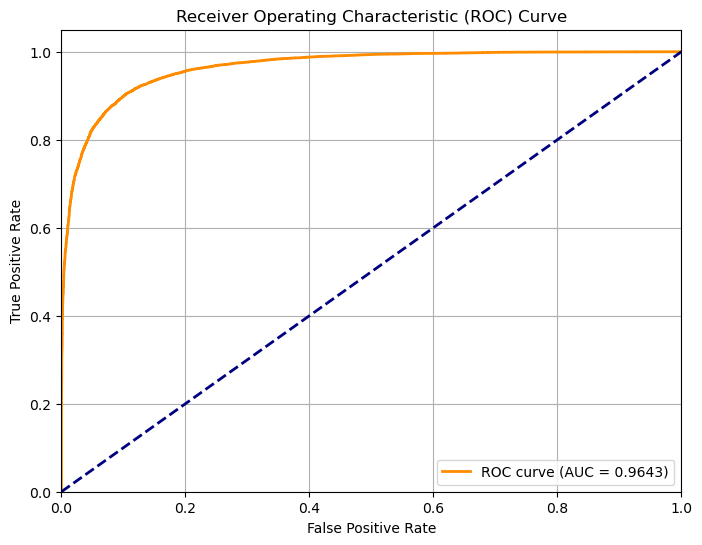


Model saved to: best_model.cbm


In [106]:
model, test_results = train_and_evaluate(
    df_train=df_train,
    df_test=df_test,
    categorical_features=categorical_features,
    numeric_features=numeric_features,
    model_path='best_model.cbm'
)

In [107]:
test_results['accuracy']

0.8975639715322277

## Model Training Summary:

1. We want to maximize precision to avoid false positives and maximize trust in the model.
2. we want to maximize recall which will lead to time and effort minimization from team.
3. F1 metrics handles it.
4. We also want to see the accuracy of the model.

All results, including the AUC score are pretty high for a claissfier, and we can say we have a good model given the current data set.


# Section 8 - Predicting on submission.csv file

In [120]:
submission = pd.read_csv('data/submission.csv')

In [121]:
merged_tmp_sub = pd.merge(submission, users_metadata, on='userId', how='left')
merged_sub = pd.merge(merged_tmp_sub, apps_metadata, on='appId', how='left')

In [122]:
merged_sub['category'] = merged_sub['category'].str.lower()
merged_sub['department'] = merged_sub['department'].fillna('unknown')
merged_sub['category'] = merged_sub['category'].fillna('novalue')
merged_sub['managerId'] = merged_sub['managerId'].fillna('novalue')

In [123]:
merged_sub['userId'] = merged_sub['userId'].astype('category')
merged_sub['appId'] = merged_sub['appId'].astype('category')
merged_sub['managerId'] = merged_sub['managerId'].astype('category')
merged_sub['department'] = merged_sub['department'].astype('category')
merged_sub['officeLocation'] = merged_sub['officeLocation'].astype('category')

In [124]:
max_seniority = merged_sub['seniority'].max()
merged_sub['seniority_inverted'] = max_seniority - merged_sub['seniority']
merged_sub['seniority_inverted'] = pd.Categorical(merged_sub['seniority_inverted'], ordered=True, categories=sorted(merged_sub['seniority_inverted'].unique()))

In [125]:
for cat_feat in categorical_features:
    merged_sub[cat_feat] = merged_sub[cat_feat].astype(str)
    merged_sub[cat_feat] = merged_sub[cat_feat].astype('category')

In [126]:
X_submission = merged_sub[categorical_features + numeric_features]
y_pred = model.predict(X_submission)
merged_sub['permission'] = y_pred
merged_sub[['userId', 'appId', 'permission']].to_csv('submission.csv', index=False)

# Assignment Summary:
1. I encountered unexpected slowness on my pc and as a result I was limited in my tries to perform different run's.
2. I didn't have enough time to use the 2 new featurues where I bin dep' and office location.
3. I didn't run param tuning.
4. Overall the reuslts of the model on the global test set are good.
5. More work need to productionize the code.